In [43]:
import graphviz
from IPython.display import display
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error

Function for visualization

In [44]:
def visualize_dec_tree(decision_tree, save_as_png=False):
    """
    Returns visualization of a decision tree or saves it as a PNG file.
    """
    dot_data = tree.export_graphviz(
        decision_tree,
        out_file=None,
        feature_names=decision_tree.feature_names_in_,
        filled=True,
    )
    graph = graphviz.Source(dot_data)

    if save_as_png:
        graph.render(filename="decision_tree", format="png", cleanup=True)
    else:
        display(graph)

Load data

In [45]:
data = load_diabetes()

diabetes_df = pd.DataFrame(data=data.data, columns=data.feature_names)
diabetes_df["target"] = data.target
diabetes_df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0


In [46]:
# create feature matrix and target vector
X = diabetes_df.drop(columns="target")
y = diabetes_df["target"]

Train decision tree on whole dataset

In [62]:
# initialize a model with default hyperparameters
overfit_model = DecisionTreeRegressor(
    max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42
)

# fit to the data
overfit_model.fit(X, y)

DecisionTreeRegressor(random_state=42)

In [63]:
# visualize tree
visualize_dec_tree(overfit_model, save_as_png=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.843619 to fit


In [51]:
# predict and evaluate
train_predictions = overfit_model.predict(X)
overfit_rmse = root_mean_squared_error(y, train_predictions)
print(f"RMSE when overfitting on the full dataset: {overfit_rmse}")

RMSE when overfitting on the full dataset: 0.0


In [52]:
y == train_predictions

0      True
1      True
2      True
3      True
4      True
       ... 
437    True
438    True
439    True
440    True
441    True
Name: target, Length: 442, dtype: bool

Train / test split

In [53]:
# train-test split, 80-20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [55]:
# Fit to train set
split_model = DecisionTreeRegressor(
    max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42
)
split_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [56]:
# Evaluate on both training and test sets
train_rmse_split = root_mean_squared_error(y_train, split_model.predict(X_train))
test_rmse_split = root_mean_squared_error(y_test, split_model.predict(X_test))

print(f"RMSE on training set (train/test split): {train_rmse_split}")
print(f"RMSE on test set (train/test split): {test_rmse_split}")

RMSE on training set (train/test split): 0.0
RMSE on test set (train/test split): 70.54642267903446


Tune hyperparameters with k-fold cross-validation

In [57]:
# define parameter grid
param_grid = {
    "max_depth": [2, 4, 6, 8, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

In [58]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(
    DecisionTreeRegressor(), param_grid, cv=5, scoring="neg_root_mean_squared_error"
)

# fit with best params
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_root_mean_squared_error')

In [59]:
# get best model from cross-validation
best_model = grid_search.best_estimator_

# print best parameters
print(grid_search.best_params_)

{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


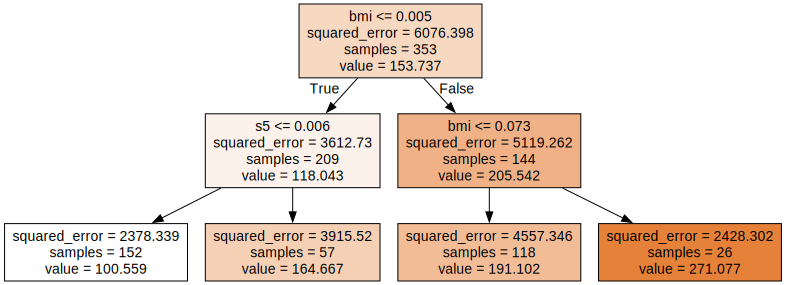

In [60]:
# visualize best tree
visualize_dec_tree(best_model, save_as_png=False)

In [61]:
print("Best parameters from cross-validation:", grid_search.best_params_)

# Evaluate the best model on both sets
best_train_rmse = root_mean_squared_error(y_train, best_model.predict(X_train))
best_test_rmse = root_mean_squared_error(y_test, best_model.predict(X_test))
print(f"Cross-validation RMSE on train set (best model): {best_train_rmse}")
print(f"Cross-validation RMSE on test set (best model): {best_test_rmse}")

Best parameters from cross-validation: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Cross-validation RMSE on train set (best model): 57.95364855870338
Cross-validation RMSE on test set (best model): 61.1187337707425
